In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [6]:
import nflib
import nflib.flows as inf
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [7]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

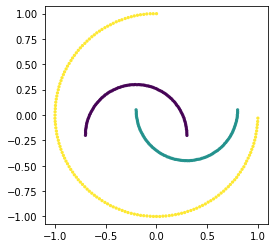

In [212]:
class DatasetMoons:
    """ two half-moons """
    def __init__(self, total_points = 1000, seed=None, noise=1):
        if seed is not None:
            np.random.seed(seed) ## 148, 249
            
        xxc, yc = datasets.make_circles(n_samples=400, factor=.5,
                                        noise=noise*.07)
        idx = yc==0
        xxc = xxc[idx]
        yc = yc[idx]
        idx = (xxc[:,0]+xxc[:,1]<1)
        xxc = xxc[idx]
        yc = yc[idx]

        xxm, ym = datasets.make_moons(n_samples=200, noise=noise*.15)
        xxm = xxm/2 - 0.2
        xx = np.concatenate((xxm, xxc), axis=0)
        y = np.concatenate((ym, yc+2), axis=0)
        
        self.x = xx
        self.c = y

    
    def sample(self, n):
        if n > len(self.x):
            n = len(self.x)
        x = self.x.astype(np.float32)
        c = self.c.astype(np.long)
        return torch.from_numpy(x), torch.from_numpy(c)

d = DatasetMoons(noise=0.01)

x,c = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.9, c=c)
plt.axis('equal');

In [213]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
        
    def forward(self, x):
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers, p=2)
#         print(dists.shape)
#         dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        return dists
    
    def reverse(self, y):
        ### here x is the distance, so weighted distance is the reversed mode
        ##### for a single input, y = mean(x_i * center_i : for i in range(num_centers))
#         z = (y.unsqueeze(2)*self.centers).sum(dim=2)/y.sum(dim=1, keepdim=True)

        idists = torch.clamp(1/y, 1e-7, 1e7)
        X_hat = (idists.unsqueeze(2)*self.centers.unsqueeze(0))
        X_hat = X_hat.sum(dim=1)/idists.unsqueeze(2).sum(dim=1)
        
        return X_hat

In [214]:
dt = DistanceTransform(2, 3)

In [215]:
X, C = d.sample(128)
Z = dt(X)

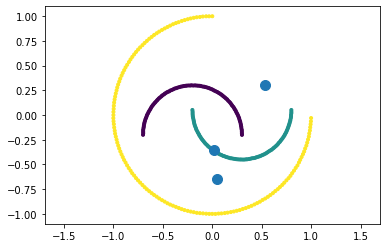

In [216]:
%matplotlib inline
center = dt.centers.data
plt.scatter(X[:, 0], X[:, 1], marker=".", c=C)
plt.scatter(center[:, 0], center[:, 1], marker="o", s=100)
plt.axis('equal');

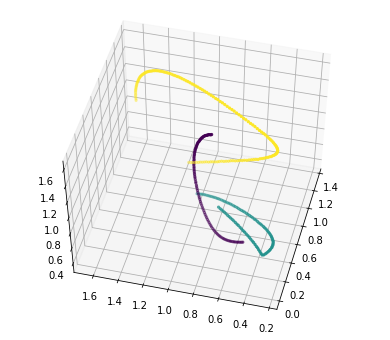

In [228]:
%matplotlib tk
z = Z.data
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.scatter(z[:,0], z[:,1], z[:,2], marker=".", c=C)
plt.show()
plt.pause(10)

In [229]:
### reconstruction
X_hat = dt.reverse(z)

In [230]:
centers = dt.centers
idists = torch.clamp(1/z, 1e-7, 1e7)
(idists.unsqueeze(2)*centers).shape

torch.Size([350, 3, 2])

In [231]:
centers.shape

torch.Size([3, 2])

In [232]:
Z.shape

torch.Size([350, 3])

In [233]:
centers.shape

torch.Size([3, 2])

In [234]:
### z is distance, we are doing inverse distance weighting w.r.t. centers
X_hat = (idists.unsqueeze(2)*centers.unsqueeze(0))
X_hat.shape

torch.Size([350, 3, 2])

In [235]:
X_hat = X_hat.sum(dim=1)/idists.unsqueeze(2).sum(dim=1)
X_hat.shape

torch.Size([350, 2])

In [236]:
idists.unsqueeze(2).sum(dim=1, keepdim=True).shape

torch.Size([350, 1, 1])

In [237]:
idists.unsqueeze(2).shape

torch.Size([350, 3, 1])

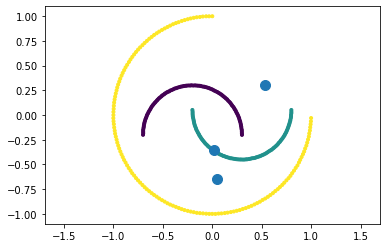

In [238]:
%matplotlib inline
center = dt.centers.data
plt.scatter(X[:, 0], X[:, 1], marker=".", c=C)
plt.scatter(center[:, 0], center[:, 1], marker="o", s=100)
plt.axis('equal');

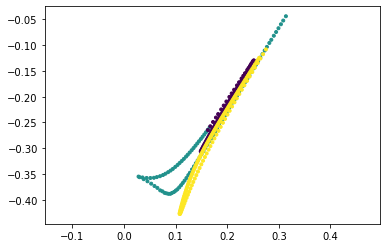

In [239]:
%matplotlib inline
center = dt.centers.data
X_ = X_hat.data
plt.scatter(X_[:, 0], X_[:, 1], marker=".", c=C)
# plt.scatter(X[:, 0], X[:, 1], marker=".", c=C, alpha=0.5, cmap='tab20b')
plt.axis('equal');